## First Step ##
- Upload the data to the Notebook. 
- create a time_ind and group cat col. 

In [115]:
import copy
from pathlib import Path
import warnings
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [116]:
# read the data 
CRYPTO_CODE = "BTC"
PATH = f"Training_Data/{CRYPTO_CODE}USDT_minute_Training_Data.xlsx" 
df_BTC = pd.read_excel(PATH)

In [117]:
df_BTC.sample(20)

,Unnamed: 0,unix,date,symbol,close,Volume USDT,hour,minute,mid_price_1,mid_price_2,EMA0,EMA1,EMA2,RSI,SMA,upper,lower,future_price,future_change
314107,314107,1621406220,2021-05-19 06:37:00,BTC/USDT,39460.3,358250.036395,6,37,39444.20,39452.15,39485.770825,39567.261307,39475.752985,36.381008,39664.135,39913.636695,39414.633305,39613.9,1
193780,193780,1614179580,2021-02-24 15:13:00,BTC/USDT,48905.4,220976.358318,15,13,48951.50,48981.30,49021.097366,48939.417523,48821.010205,24.675998,49286.165,49692.320797,48880.009203,48957.6,1
20648,20648,1603772400,2020-10-27 04:20:00,BTC/USDT,13108.2,14463.972146,4,20,13106.20,13106.15,13105.333998,13100.791002,13098.700595,57.480315,13100.940,13109.569301,13092.310699,13104.6,0
380887,380887,1625413020,2021-07-04 15:37:00,BTC/USDT,35492.7,41940.367040,15,37,35485.60,35494.50,35491.832994,35475.551853,35475.957413,57.855823,35458.390,35492.806514,35423.973486,35475.0,0
330803,330803,1622407980,2021-05-30 20:53:00,BTC/USDT,36232.1,253671.341528,20,53,36214.70,36216.95,36156.651347,36104.987304,36055.679344,57.429614,36127.930,36267.557536,35988.302464,36092.2,0
73973,73973,1606972980,2020-12-03 05:23:00,BTC/USDT,19104.9,15560.369835,5,23,19106.60,19106.55,19104.875018,19098.083249,19091.504736,56.087220,19075.080,19115.933401,19034.226599,19103.7,0
336999,336999,1622779740,2021-06-04 04:09:00,BTC/USDT,37869.7,178344.985326,4,9,37853.45,37846.70,37843.297593,37860.119366,37831.353504,49.446254,37863.640,37930.297598,37796.982402,37837.9,0
205958,205958,1614910260,2021-03-05 02:11:00,BTC/USDT,46628.0,86895.282370,2,11,46654.30,46627.15,46642.333106,46703.988446,46759.844704,48.313539,46599.500,46771.928181,46427.071819,46761.3,1
222277,222277,1615889400,2021-03-16 10:10:00,BTC/USDT,56030.7,367921.060186,10,10,56025.80,56040.25,56016.363829,55939.187592,55996.003885,58.371347,55951.935,56156.535666,55747.334334,55876.1,0
246821,246821,1617362040,2021-04-02 11:14:00,BTC/USDT,59555.9,28098.503045,11,14,59545.30,59545.30,59531.400733,59567.237509,59546.813043,35.887787,59578.765,59648.172940,59509.357060,59559.6,1


In [118]:
df_BTC.columns

Index(['Unnamed: 0', 'unix', 'date', 'symbol', 'close', 'Volume USDT', 'hour',
       'minute', 'mid_price_1', 'mid_price_2', 'EMA0', 'EMA1', 'EMA2', 'RSI',
       'SMA', 'upper', 'lower', 'future_price', 'future_change'],
      dtype='object')

In [119]:
df_BTC.rename(columns={"Unnamed: 0": "time_ind"}, inplace=True)

In [120]:
df_BTC.columns

Index(['time_ind', 'unix', 'date', 'symbol', 'close', 'Volume USDT', 'hour',
       'minute', 'mid_price_1', 'mid_price_2', 'EMA0', 'EMA1', 'EMA2', 'RSI',
       'SMA', 'upper', 'lower', 'future_price', 'future_change'],
      dtype='object')

In [121]:
df_BTC.head(10)

,time_ind,unix,date,symbol,close,Volume USDT,hour,minute,mid_price_1,mid_price_2,EMA0,EMA1,EMA2,RSI,SMA,upper,lower,future_price,future_change
0,0,1602533520,2020-10-12 20:12:00,BTC/USDT,11554.1,9673.306824,20,12,11553.60,11554.70,11555.272349,11555.893090,11557.150449,53.333333,11550.460,11560.349793,11540.570207,11555.6,1
1,1,1602533580,2020-10-12 20:13:00,BTC/USDT,11555.3,3796.462482,20,13,11554.70,11554.70,11555.436174,11556.952207,11558.180359,54.621849,11550.805,11560.872033,11540.737967,11556.4,1
2,2,1602533640,2020-10-12 20:14:00,BTC/USDT,11555.8,7366.568423,20,14,11555.25,11555.60,11555.918087,11557.651577,11559.544287,56.866953,11551.025,11561.336133,11540.713867,11558.0,1
3,3,1602533700,2020-10-12 20:15:00,BTC/USDT,11555.6,17479.106516,20,15,11554.90,11555.70,11556.959044,11558.179698,11560.635430,56.531049,11551.100,11561.526484,11540.673516,11559.6,1
4,4,1602533760,2020-10-12 20:16:00,BTC/USDT,11556.4,4726.867634,20,16,11556.00,11556.00,11558.279522,11559.356927,11560.668344,49.502488,11551.095,11561.510671,11540.679329,11559.4,1
5,5,1602533820,2020-10-12 20:17:00,BTC/USDT,11558.0,9502.689987,20,17,11557.15,11557.15,11558.839761,11560.969233,11561.334675,71.428571,11551.225,11561.927853,11540.522147,11559.5,1
6,6,1602533880,2020-10-12 20:18:00,BTC/USDT,11559.6,10298.345764,20,18,11558.75,11558.80,11559.169880,11562.120881,11562.307740,87.169811,11551.655,11562.992033,11540.317967,11562.3,1
7,7,1602533940,2020-10-12 20:19:00,BTC/USDT,11559.4,2391.725090,20,19,11559.70,11559.65,11560.734940,11561.743486,11563.486192,84.810127,11552.080,11563.923826,11540.236174,11565.0,1
8,8,1602534000,2020-10-12 20:20:00,BTC/USDT,11559.5,1179.413136,20,20,11559.45,11559.45,11562.867470,11562.388205,11564.608954,84.615385,11552.585,11564.803067,11540.366933,11565.0,1
9,9,1602534060,2020-10-12 20:21:00,BTC/USDT,11562.3,9303.625405,20,21,11561.65,11560.85,11563.933735,11563.477289,11565.487163,83.710407,11553.225,11566.086673,11540.363327,11560.8,0


In [122]:
df_BTC["time_ind"] = pd.to_numeric(df_BTC["time_ind"])
df_BTC["symbol"] = df_BTC["symbol"].astype("category")
df_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447884 entries, 0 to 447883
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   time_ind       447884 non-null  int64         
 1   unix           447884 non-null  int64         
 2   date           447884 non-null  datetime64[ns]
 3   symbol         447884 non-null  category      
 4   close          447884 non-null  float64       
 5   Volume USDT    447884 non-null  float64       
 6   hour           447884 non-null  int64         
 7   minute         447884 non-null  int64         
 8   mid_price_1    447884 non-null  float64       
 9   mid_price_2    447884 non-null  float64       
 10  EMA0           447884 non-null  float64       
 11  EMA1           447884 non-null  float64       
 12  EMA2           447884 non-null  float64       
 13  RSI            447884 non-null  float64       
 14  SMA            447884 non-null  float64       
 15  

In [123]:
df_BTC.head(60)

,time_ind,unix,date,symbol,close,Volume USDT,hour,minute,mid_price_1,mid_price_2,EMA0,EMA1,EMA2,RSI,SMA,upper,lower,future_price,future_change
0,0,1602533520,2020-10-12 20:12:00,BTC/USDT,11554.1,9673.306824,20,12,11553.60,11554.70,11555.272349,11555.893090,11557.150449,53.333333,11550.460,11560.349793,11540.570207,11555.6,1
1,1,1602533580,2020-10-12 20:13:00,BTC/USDT,11555.3,3796.462482,20,13,11554.70,11554.70,11555.436174,11556.952207,11558.180359,54.621849,11550.805,11560.872033,11540.737967,11556.4,1
2,2,1602533640,2020-10-12 20:14:00,BTC/USDT,11555.8,7366.568423,20,14,11555.25,11555.60,11555.918087,11557.651577,11559.544287,56.866953,11551.025,11561.336133,11540.713867,11558.0,1
3,3,1602533700,2020-10-12 20:15:00,BTC/USDT,11555.6,17479.106516,20,15,11554.90,11555.70,11556.959044,11558.179698,11560.635430,56.531049,11551.100,11561.526484,11540.673516,11559.6,1
4,4,1602533760,2020-10-12 20:16:00,BTC/USDT,11556.4,4726.867634,20,16,11556.00,11556.00,11558.279522,11559.356927,11560.668344,49.502488,11551.095,11561.510671,11540.679329,11559.4,1
5,5,1602533820,2020-10-12 20:17:00,BTC/USDT,11558.0,9502.689987,20,17,11557.15,11557.15,11558.839761,11560.969233,11561.334675,71.428571,11551.225,11561.927853,11540.522147,11559.5,1
6,6,1602533880,2020-10-12 20:18:00,BTC/USDT,11559.6,10298.345764,20,18,11558.75,11558.80,11559.169880,11562.120881,11562.307740,87.169811,11551.655,11562.992033,11540.317967,11562.3,1
7,7,1602533940,2020-10-12 20:19:00,BTC/USDT,11559.4,2391.725090,20,19,11559.70,11559.65,11560.734940,11561.743486,11563.486192,84.810127,11552.080,11563.923826,11540.236174,11565.0,1
8,8,1602534000,2020-10-12 20:20:00,BTC/USDT,11559.5,1179.413136,20,20,11559.45,11559.45,11562.867470,11562.388205,11564.608954,84.615385,11552.585,11564.803067,11540.366933,11565.0,1
9,9,1602534060,2020-10-12 20:21:00,BTC/USDT,11562.3,9303.625405,20,21,11561.65,11560.85,11563.933735,11563.477289,11565.487163,83.710407,11553.225,11566.086673,11540.363327,11560.8,0


In [124]:
df_BTC = df_BTC.iloc[48:]
# df_BTC.reset_index(drop=True)


In [125]:
# df_BTC.drop(["time_ind", "unix", "date", "future_change"], axis=1,  inplace=True)
# df_BTC
df_BTC

,time_ind,unix,date,symbol,close,Volume USDT,hour,minute,mid_price_1,mid_price_2,EMA0,EMA1,EMA2,RSI,SMA,upper,lower,future_price,future_change
48,48,1602536400,2020-10-12 21:00:00,BTC/USDT,11559.6,4019.047285,21,0,11559.85,11559.85,11559.687453,11563.069122,11566.809205,40.221402,11560.990,11571.178311,11550.801689,11563.4,1
49,49,1602536460,2020-10-12 21:01:00,BTC/USDT,11558.6,3035.890463,21,1,11559.00,11559.05,11561.543726,11564.563659,11568.087364,54.500000,11560.565,11570.382551,11550.747449,11563.9,1
50,50,1602536520,2020-10-12 21:02:00,BTC/USDT,11560.2,915.963208,21,2,11559.40,11559.40,11562.721863,11565.774042,11569.489891,55.172414,11560.275,11569.753369,11550.796631,11566.9,1
51,51,1602536580,2020-10-12 21:03:00,BTC/USDT,11563.4,1302.013684,21,3,11561.80,11561.80,11564.810932,11568.752887,11570.731913,69.565217,11560.025,11568.841701,11551.208299,11568.3,1
52,52,1602536640,2020-10-12 21:04:00,BTC/USDT,11563.9,3010.812664,21,4,11563.65,11563.65,11566.555466,11570.023491,11571.725531,66.489362,11559.675,11567.123596,11552.226404,11568.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447879,447879,1629444420,2021-08-20 07:27:00,BTC/USDT,47085.1,133184.447056,7,27,47090.80,47086.90,47057.775894,47029.444027,47001.746445,50.584958,47108.075,47157.551454,47058.598546,47020.0,0
447880,447880,1629444480,2021-08-20 07:28:00,BTC/USDT,47041.7,132977.591814,7,28,47063.35,47063.35,47038.887947,47019.345734,46980.977156,44.861660,47102.685,47156.460724,47048.909276,47003.4,0
447881,447881,1629444540,2021-08-20 07:29:00,BTC/USDT,47050.4,180183.705695,7,29,47046.90,47046.05,47021.143973,47001.332667,46965.861725,37.513998,47099.395,47157.561312,47041.228688,46999.0,0
447882,447882,1629444600,2021-08-20 07:30:00,BTC/USDT,47020.0,126677.583573,7,30,47042.25,47035.20,47010.071987,46982.066191,46947.949380,30.049261,47094.560,47162.005616,47027.114384,46994.1,0


In [126]:
df_BTC.drop(["unix", "date", "future_change"], axis=1,  inplace=True)
df_BTC.columns

Index(['time_ind', 'symbol', 'close', 'Volume USDT', 'hour', 'minute',
       'mid_price_1', 'mid_price_2', 'EMA0', 'EMA1', 'EMA2', 'RSI', 'SMA',
       'upper', 'lower', 'future_price'],
      dtype='object')

In [42]:
# df_BTC.rename(columns={"minute": "time_ind"}, inplace=True)

In [127]:
# Checkpoint 
df_BTC.to_pickle("./BTC_future_price.pkl")

In [128]:
# df_BTC_training, df_BTC_testing = df_BTC.iloc[:(int(len(df_BTC)*0.9))], df_BTC.iloc[(int(len(df_BTC)*0.9)):]
# print(len(df_BTC_training))
# print(len(df_BTC_testing))

In [129]:
# df_BTC

In [130]:
# df_BTC["hour"] = df_BTC["hour"].astype("str")
# df_BTC["hour"] = df_BTC["hour"].astype("category")

In [131]:
# df_BTC.drop(["unix", "date", "future_change"], axis=1,  inplace=True)
df_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447836 entries, 48 to 447883
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   time_ind      447836 non-null  int64   
 1   symbol        447836 non-null  category
 2   close         447836 non-null  float64 
 3   Volume USDT   447836 non-null  float64 
 4   hour          447836 non-null  int64   
 5   minute        447836 non-null  int64   
 6   mid_price_1   447836 non-null  float64 
 7   mid_price_2   447836 non-null  float64 
 8   EMA0          447836 non-null  float64 
 9   EMA1          447836 non-null  float64 
 10  EMA2          447836 non-null  float64 
 11  RSI           447836 non-null  float64 
 12  SMA           447836 non-null  float64 
 13  upper         447836 non-null  float64 
 14  lower         447836 non-null  float64 
 15  future_price  447836 non-null  float64 
dtypes: category(1), float64(12), int64(3)
memory usage: 51.7 MB


In [158]:
df_BTC_training, df_BTC_testing = df_BTC.iloc[:(int(len(df_BTC)*0.9))], df_BTC.iloc[(int(len(df_BTC)*0.9)):]
df_BTC_train, df_BTC_valid = df_BTC_training.iloc[:(int(len(df_BTC_training)*0.9))], df_BTC_training.iloc[(int(len(df_BTC_training)*0.9)):]
print(len(df_BTC_training))
print(len(df_BTC_testing))
print(len(df_BTC_valid))

403052
44784
40306


In [170]:
df_BTC_valid

,time_ind,symbol,close,Volume USDT,hour,minute,mid_price_1,mid_price_2,EMA0,EMA1,EMA2,RSI,SMA,upper,lower,future_price
362794,362794,BTC/USDT,32667.1,48215.510027,2,4,32648.25,32652.70,32629.348768,32563.321142,32550.713811,55.484634,32656.860,32745.008998,32568.711002,32602.2
362795,362795,BTC/USDT,32633.0,206952.084420,2,5,32648.10,32650.10,32615.774384,32535.743673,32562.931049,53.244102,32656.440,32744.978339,32567.901661,32513.3
362796,362796,BTC/USDT,32616.4,139978.178029,2,6,32632.35,32619.85,32564.537192,32521.445480,32589.864839,44.087371,32652.060,32739.350185,32564.769815,32487.5
362797,362797,BTC/USDT,32602.2,137329.364197,2,7,32625.35,32609.35,32526.018596,32536.375343,32602.791871,43.932950,32644.025,32716.720874,32571.329126,32466.8
362798,362798,BTC/USDT,32513.3,220372.357779,2,8,32553.25,32558.10,32496.409298,32557.925245,32598.373497,36.960640,32632.295,32709.957468,32554.632532,32485.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403095,403095,BTC/USDT,30618.3,33566.149109,2,16,30607.80,30604.10,30596.949883,30549.358840,30468.213042,38.445109,30623.630,30683.971732,30563.288268,30500.0
403096,403096,BTC/USDT,30613.4,6572.831118,2,17,30617.25,30615.85,30548.474942,30526.713457,30447.930434,39.560440,30622.025,30681.620439,30562.429561,30516.5
403097,403097,BTC/USDT,30585.4,74525.089880,2,18,30599.35,30599.35,30532.487471,30479.395327,30426.404347,38.428693,30618.820,30679.084771,30558.555229,30533.8
403098,403098,BTC/USDT,30500.0,419850.542123,2,19,30514.55,30542.45,30533.143735,30431.796662,30410.343478,29.595528,30612.805,30693.124952,30532.485048,30470.1


In [167]:
max_prediction_length = 8
max_encoder_length = 45
training_cutoff = 380000 # - max_prediction_length

training = TimeSeriesDataSet(
    df_BTC_train,
    time_idx="time_ind",
    target="future_price",
    group_ids=["symbol"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["symbol"],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["minute", "hour", "time_ind"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'close',
        'Volume USDT',
        'mid_price_1',
       'mid_price_2',
        'EMA0',
        'EMA1',
        'EMA2',
        'RSI',
        'SMA',
        'upper',
        'lower',
       'future_price',
    ],
    target_normalizer=EncoderNormalizer(
        transformation="relu"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)




In [173]:
validation = TimeSeriesDataSet(
    df_BTC_valid,
    time_idx="time_ind",
    target="future_price",
    group_ids=["symbol"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["symbol"],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["minute", "hour", "time_ind"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'close',
        'Volume USDT',
        'mid_price_1',
       'mid_price_2',
        'EMA0',
        'EMA1',
        'EMA2',
        'RSI',
        'SMA',
        'upper',
        'lower',
       'future_price',
    ],
    target_normalizer=EncoderNormalizer(
        transformation="relu"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,  
    
)
print(len(validation))

40314


In [174]:
training.get_parameters()

{'time_idx': 'time_ind',
 'target': 'future_price',
 'group_ids': ['symbol'],
 'weight': None,
 'max_encoder_length': 45,
 'min_encoder_length': 22,
 'min_prediction_idx': 48,
 'min_prediction_length': 1,
 'max_prediction_length': 8,
 'static_categoricals': ['symbol'],
 'static_reals': ['encoder_length',
  'future_price_center',
  'future_price_scale'],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': ['minute',
  'hour',
  'time_ind',
  'relative_time_idx'],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['close',
  'Volume USDT',
  'mid_price_1',
  'mid_price_2',
  'EMA0',
  'EMA1',
  'EMA2',
  'RSI',
  'SMA',
  'upper',
  'lower',
  'future_price'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': True,
 'add_target_scales': True,
 'add_encoder_length': True,
 'target_normalizer': EncoderNormalizer(transformation='relu'),
 'categorical_encoders': {'__group_id_

In [175]:
validation.get_parameters()

{'time_idx': 'time_ind',
 'target': 'future_price',
 'group_ids': ['symbol'],
 'weight': None,
 'max_encoder_length': 45,
 'min_encoder_length': 22,
 'min_prediction_idx': 362794,
 'min_prediction_length': 1,
 'max_prediction_length': 8,
 'static_categoricals': ['symbol'],
 'static_reals': ['encoder_length',
  'future_price_center',
  'future_price_scale'],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': ['minute',
  'hour',
  'time_ind',
  'relative_time_idx'],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['close',
  'Volume USDT',
  'mid_price_1',
  'mid_price_2',
  'EMA0',
  'EMA1',
  'EMA2',
  'RSI',
  'SMA',
  'upper',
  'lower',
  'future_price'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': True,
 'add_target_scales': True,
 'add_encoder_length': True,
 'target_normalizer': EncoderNormalizer(transformation='relu'),
 'categorical_encoders': {'__group

In [176]:
print(len(training))
print(len(validation))

362754
40314


In [177]:
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
train_dataloader

In [178]:
# and load the first batch
x, y = next(iter(train_dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]]), 'encoder_cont': tensor([[[ 1.0000e+00,  9.6182e+14, -4.3493e+15,  ...,  1.3215e+00,
           1.3428e+00,  2.5273e+00],
         [ 1.0000e+00,  9.6182e+14, -4.3493e+15,  ...,  1.3213e+00,
           1.3435e+00,  2.0069e+00],
         [ 1.0000e+00,  9.6182e+14, -4.3493e+15,  ...,  1.3213e+00,
           1.3439e+00,  1.6036e+00],
         ...,
         [ 1.0000e+0

In [179]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

nan

In [181]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 2.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 228),
    attention_head_size_range=(1, 10),
    learning_rate_range=(0.0001, 1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=60),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2021-08-28 17:41:54,060] A new study created in memory with name: no-name-197df57f-77c0-422b-a827-550a5ab9eaef
C:\Crypto_Bot_Project\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:446: UserWarning: Checkpoint directory optuna_test\trial_0 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Crypto_Bot_Project\lib\site-packages\pytorch_lightning\trainer\trainer.py:818: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
C:\Crypto_Bot_Project\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0

C:\Crypto_Bot_Project\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Finding best initial lr:   6%|██████                                                                                               | 6/100 [00:04<01:17,  1.21it/s]C:\Crypto_Bot_Project\lib\site-packages\pytorch_lightning\trainer\trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LR finder stopped early after 6 steps due to diverging loss.
Restoring states from the checkpoint file at C:\Crypto_Bot_Project\lr_find_temp_model.ckpt
Restored all states from the checkpoint file at C:\Crypto_Bot_Project\lr_find_tem

KeyboardInterrupt: 

In [183]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
# actuals = torch.cat([print(y) for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
print(baseline_predictions)
(actuals - baseline_predictions).abs().mean().item()

tensor([[32661.8008, 32661.8008, 32661.8008,  ..., 32661.8008, 32661.8008,
         32661.8008],
        [32689.0996, 32689.0996, 32689.0996,  ..., 32689.0996, 32689.0996,
         32689.0996],
        [32686.5000, 32686.5000, 32686.5000,  ..., 32686.5000, 32686.5000,
         32686.5000],
        ...,
        [32740.5000, 32740.5000, 32740.5000,  ..., 32740.5000, 32740.5000,
         32740.5000],
        [32716.3008, 32716.3008, 32716.3008,  ..., 32716.3008, 32716.3008,
         32716.3008],
        [32692.5000, 32692.5000, 32692.5000,  ..., 32692.5000, 32692.5000,
         32692.5000]])


nan

In [184]:
# configure network and trainer
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=20,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.0246,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0398,
    hidden_size=38,
    attention_head_size=4,
    dropout=0.18,
    hidden_continuous_size=16,
#     output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 127.8k


In [185]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 608   
4  | static_variable_selection          | VariableSelectionNetwork        | 6.6 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 38.5 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 8.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 6.0 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 6.0 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 6.0 

Validation sanity check:   0%|                                                                                                               | 0/2 [00:00<?, ?it/s]

C:\Crypto_Bot_Project\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 42
C:\Crypto_Bot_Project\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Crypto_Bot_Project\lib\site-packages\pytorch_lightning\trainer\data_loading.py:322: UserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  48%|███████████████████████████████████▊                                      | 30/62 [00:34<00:35,  1.11s/it, loss=46.3, v_num=4, train_loss_step=38.50]
Validating: 0it [00:00, ?it/s]
Epoch 1:  48%|████████████████▍                 | 30/62 [00:30<00:31,  1.03it/s, loss=38.3, v_num=4, train_loss_step=31.90, val_loss=26.70, train_loss_epoch=55.30]
Validating: 0it [00:00, ?it/s]
Validating:  38%|██████████████████████████████████████████▊                                                                       | 12/32 [00:49<01:25,  4.26s/it]


Epoch 2:  48%|████████████████▍                 | 30/62 [00:29<00:30,  1.05it/s, loss=35.9, v_num=4, train_loss_step=35.70, val_loss=26.10, train_loss_epoch=38.30]
Validating: 0it [00:00, ?it/s]
Validating:  81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 26/32 [01:46<00:24,  4.03s/it]


Epoch 3:  48%|█████████████████▍                  | 30/62 [00:30<00:31,  1.03it/s, loss=30, v_num=4, train_loss_step=28.80, val_loss=23.00, train_loss_epoch=36.40]
Validating: 0it [00:00, ?it/s]
Epoch 4:  48%|████████████████▍                 | 30/62 [00:30<00:31,  1.02it/s, loss=25.7, v_num=4, train_loss_step=25.30, val_loss=19.60, train_loss_epoch=30.30]
Validating: 0it [00:00, ?it/s]
Validating:  19%|█████████████████████▌                                                                                             | 6/32 [00:25<01:47,  4.12s/it]


Epoch 5:  48%|████████████████▍                 | 30/62 [00:30<00:30,  1.03it/s, loss=23.4, v_num=4, train_loss_step=25.60, val_loss=17.70, train_loss_epoch=26.10]
Validating: 0it [00:00, ?it/s]
Validating:  62%|███████████████████████████████████████████████████████████████████████▎                                          | 20/32 [01:20<00:48,  4.02s/it]


Epoch 6:  48%|████████████████▍                 | 30/62 [00:29<00:30,  1.05it/s, loss=23.8, v_num=4, train_loss_step=22.20, val_loss=16.40, train_loss_epoch=24.30]
Validating: 0it [00:00, ?it/s]
Epoch 7:  48%|████████████████▍                 | 30/62 [00:29<00:30,  1.04it/s, loss=23.1, v_num=4, train_loss_step=25.20, val_loss=15.40, train_loss_epoch=23.70]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                                                           | 0/32 [00:00<?, ?it/s]


Epoch 8:  48%|████████████████▍                 | 30/62 [00:29<00:30,  1.03it/s, loss=23.4, v_num=4, train_loss_step=21.30, val_loss=15.90, train_loss_epoch=22.80]
Validating: 0it [00:00, ?it/s]
Validating:  44%|█████████████████████████████████████████████████▉                                                                | 14/32 [00:57<01:14,  4.13s/it]


Epoch 9:  48%|████████████████▍                 | 30/62 [00:29<00:30,  1.06it/s, loss=23.1, v_num=4, train_loss_step=25.10, val_loss=14.90, train_loss_epoch=23.10]
Validating: 0it [00:00, ?it/s]
Validating:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 28/32 [01:54<00:16,  4.04s/it]


Epoch 10:  48%|███████████████▉                 | 30/62 [00:30<00:31,  1.03it/s, loss=21.9, v_num=4, train_loss_step=19.50, val_loss=14.80, train_loss_epoch=22.90]
Validating: 0it [00:00, ?it/s]
Epoch 11:   3%|█                                 | 2/62 [00:03<01:07,  1.12s/it, loss=21.8, v_num=4, train_loss_step=20.10, val_loss=14.70, train_loss_epoch=22.10]

C:\Crypto_Bot_Project\lib\site-packages\pytorch_lightning\trainer\trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [186]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [187]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(nan)

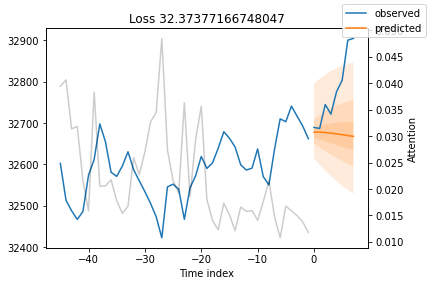

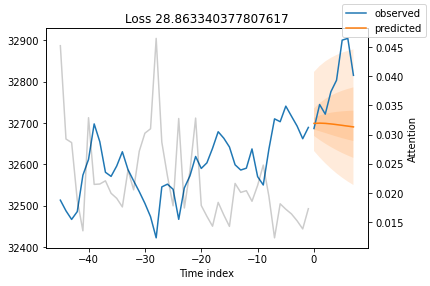

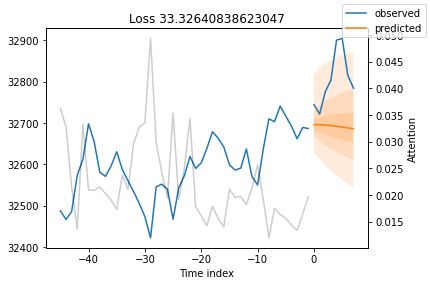

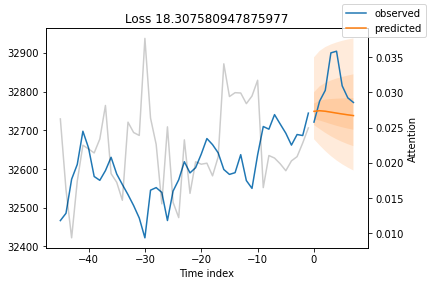

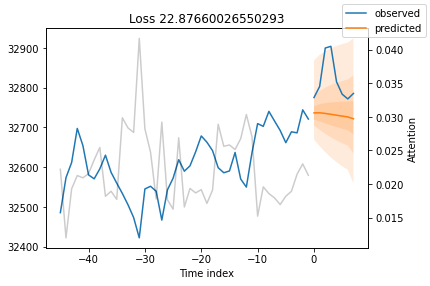

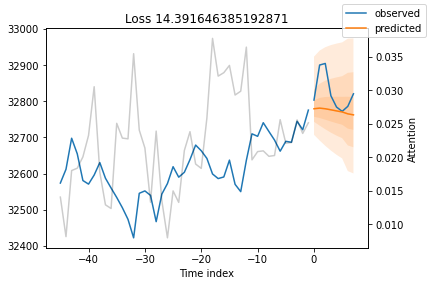

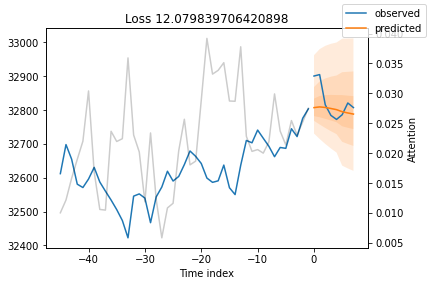

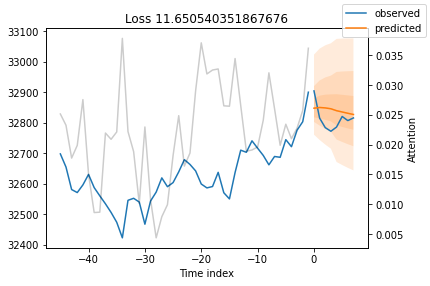

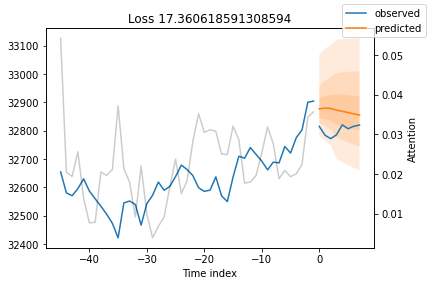

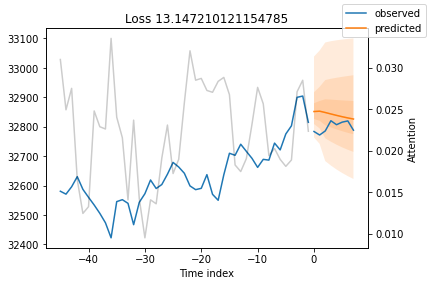

In [188]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

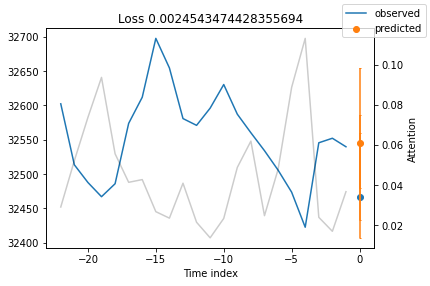

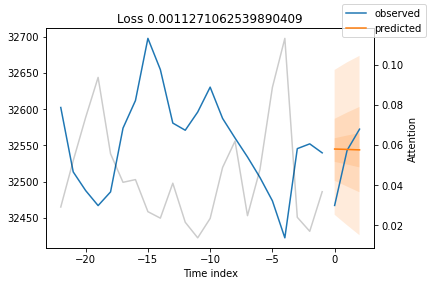

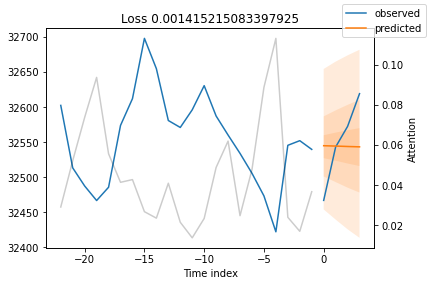

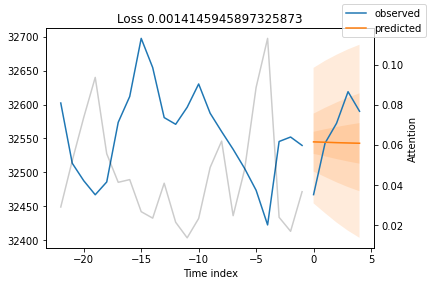

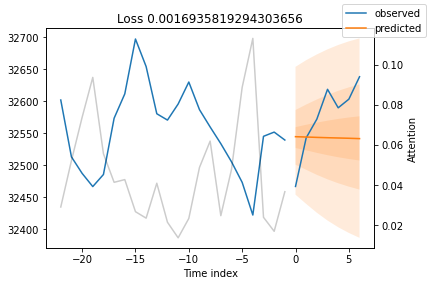

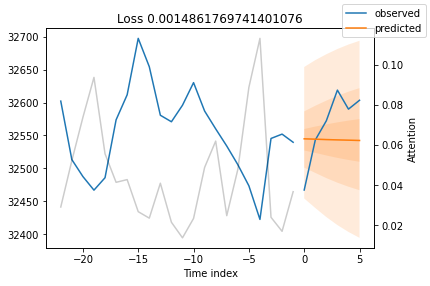

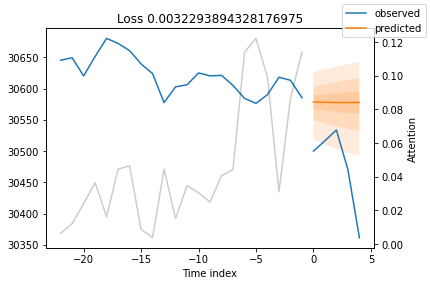

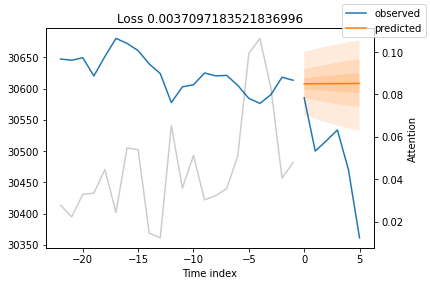

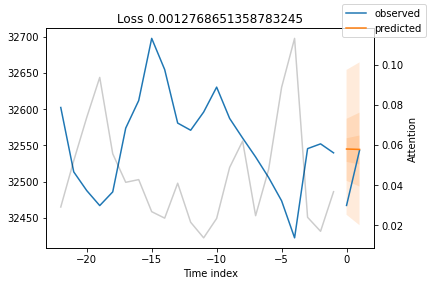

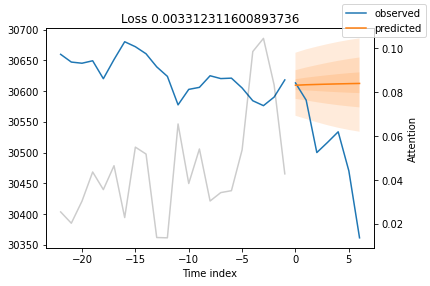

In [189]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

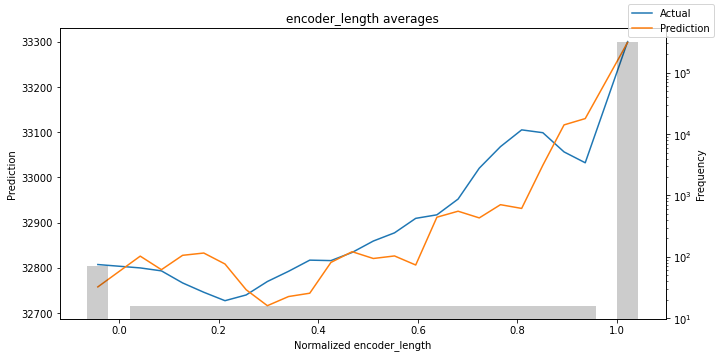

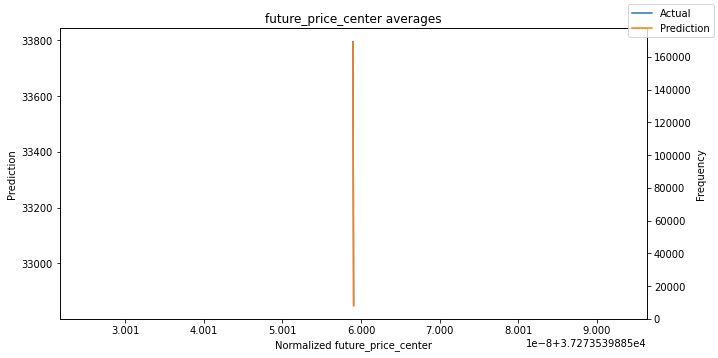

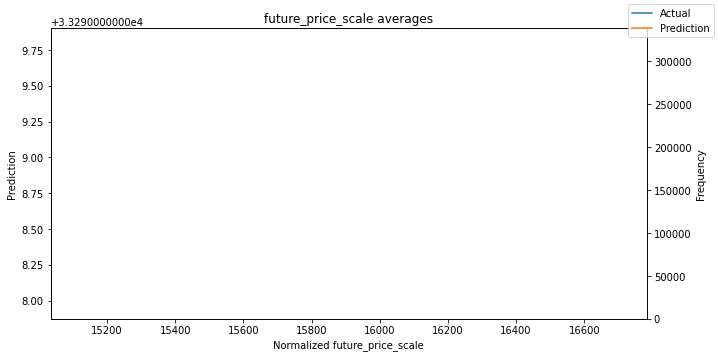

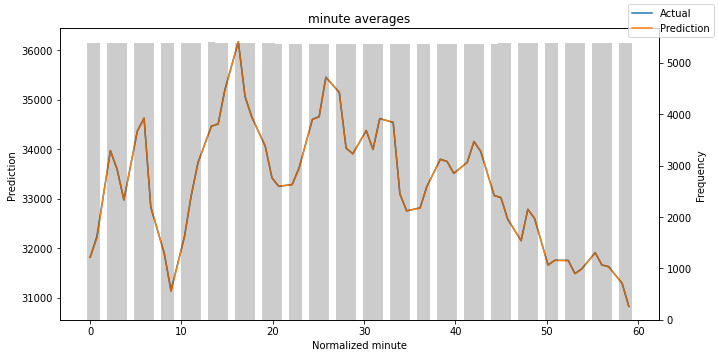

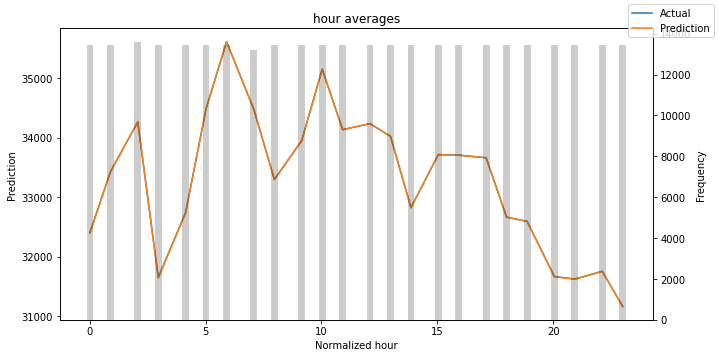

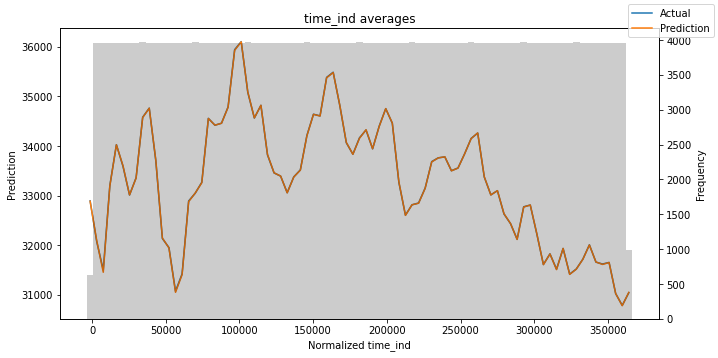

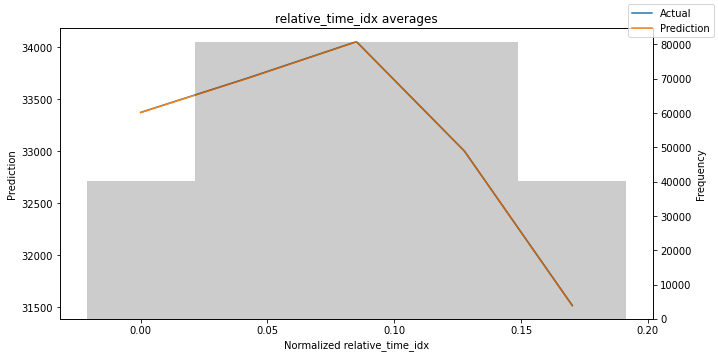

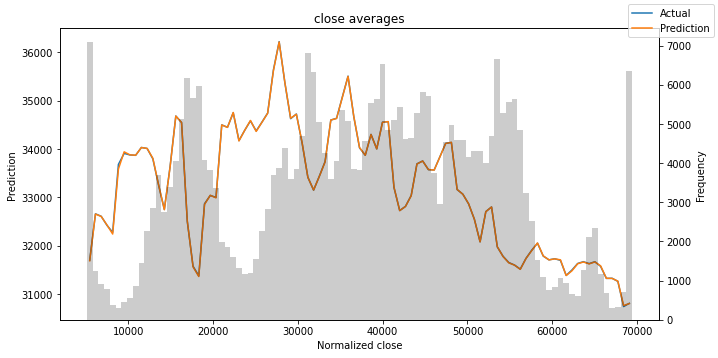

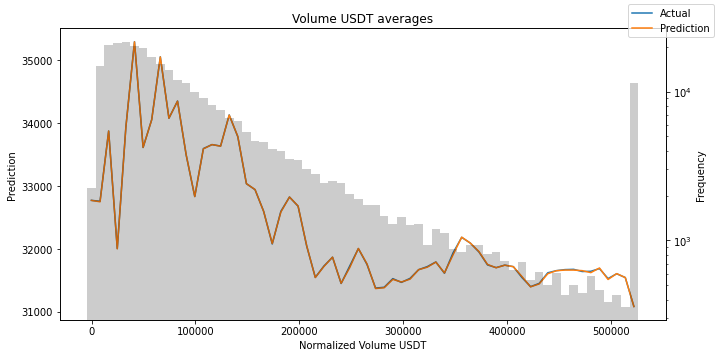

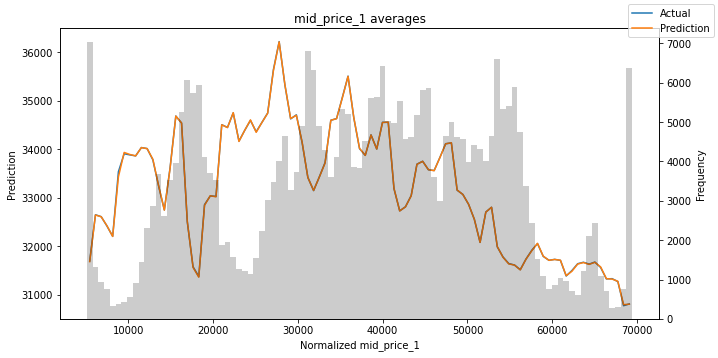

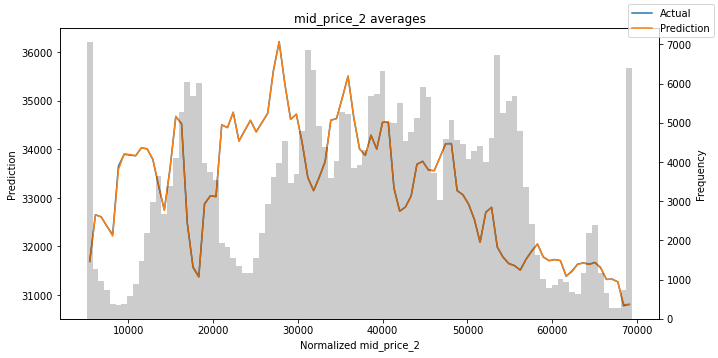

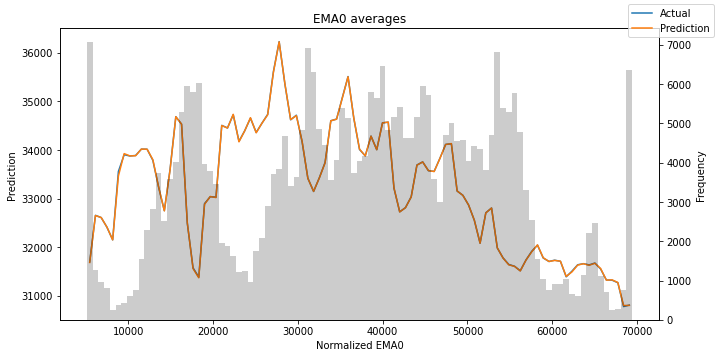

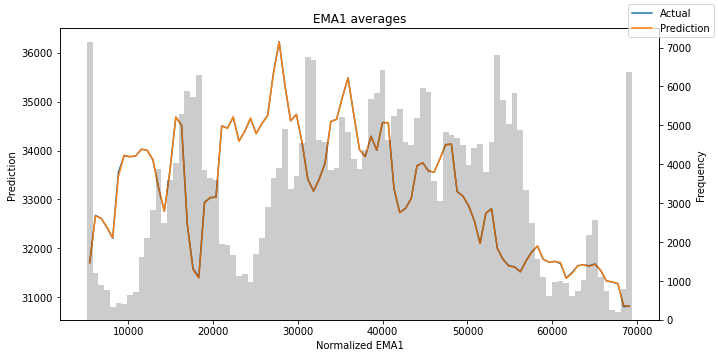

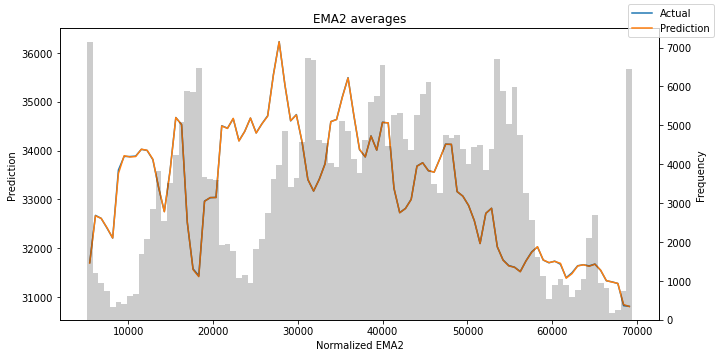

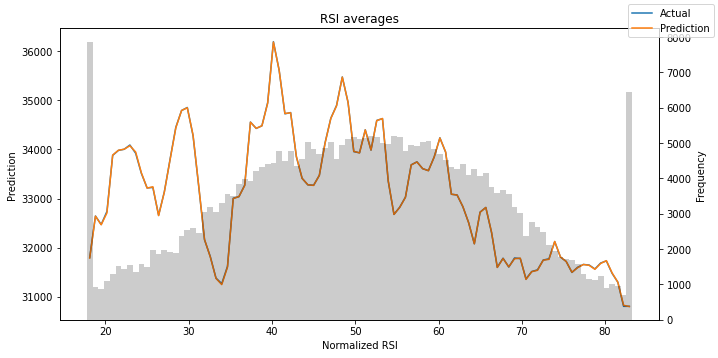

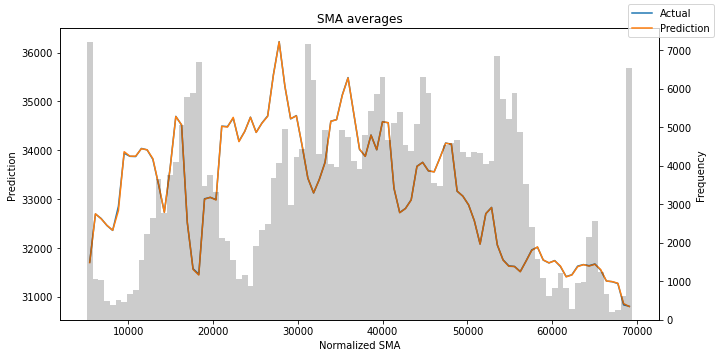

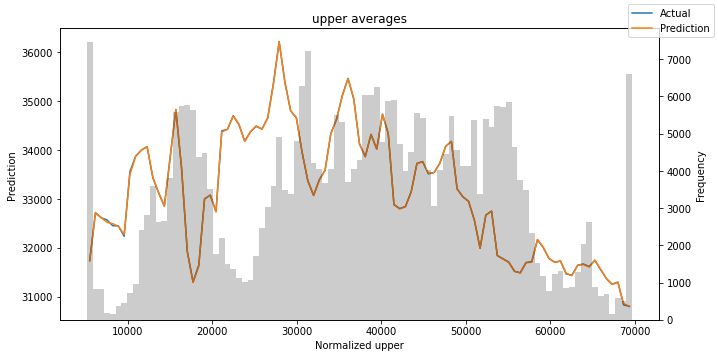

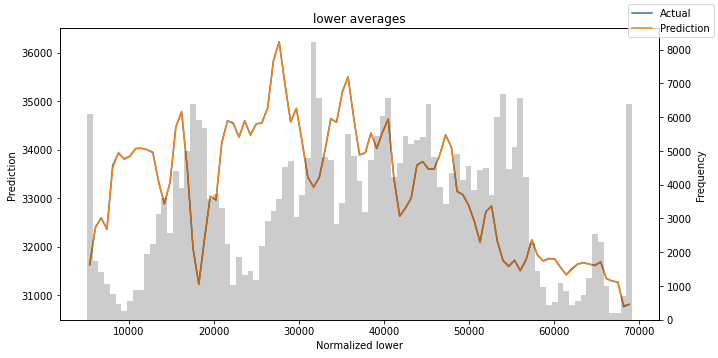

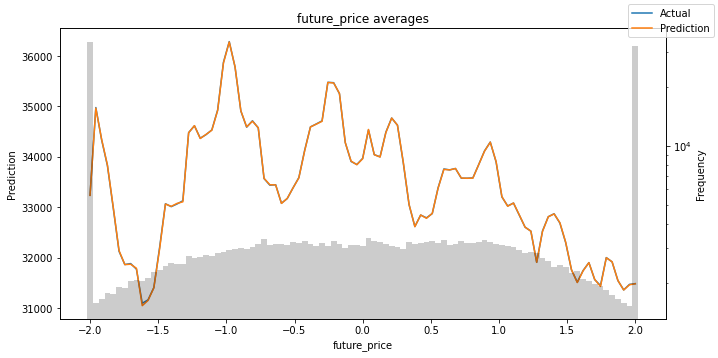

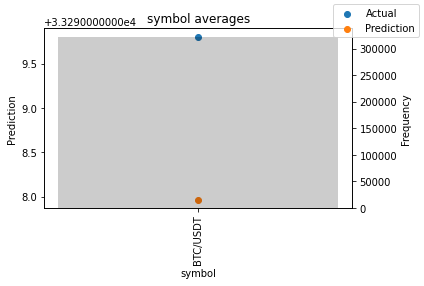

In [190]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);